# CNV Processing

In this notebook, I'm going to parse, filter, and annotate the Genome Strip and Lumpy
results. I need to figure out which CNVs I can use to for the eQTL analysis and an
mCNV analysis.

In [1]:
import cPickle
import datetime
import glob
import os
import random
import re
import subprocess
import urllib2

import cdpybio as cpb
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import pybedtools as pbt
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import vcf as pyvcf

import cardipspy as cpy
import ciepy

%matplotlib inline

dy_name = 'cnv_processing'

import socket
if socket.gethostname() == 'fl-hn1' or socket.gethostname() == 'fl-hn2':
    dy = os.path.join(ciepy.root, 'sandbox', 'tmp', dy_name)
    cpy.makedir(dy)
    pbt.set_tempdir(dy)
    
outdir = os.path.join(ciepy.root, 'output', dy_name)
cpy.makedir(outdir)

private_outdir = os.path.join(ciepy.root, 'private_output', dy_name)
cpy.makedir(private_outdir)

In [2]:
fn = os.path.join(ciepy.root, 'output', 'input_data', 'rsem_tpm.tsv')
tpm = pd.read_table(fn, index_col=0)
fn = os.path.join(ciepy.root, 'output', 'input_data', 'rnaseq_metadata.tsv')
rna_meta = pd.read_table(fn, index_col=0)
fn = os.path.join(ciepy.root, 'output', 'eqtl_input', 'unrelateds.tsv')
unr_rna_meta = pd.read_table(fn, index_col=0)
fn = os.path.join(ciepy.root, 'output', 'input_data', 'subject_metadata.tsv')
subject_meta = pd.read_table(fn, index_col=0)
fn = os.path.join(ciepy.root, 'output', 'input_data', 'wgs_metadata.tsv')
wgs_meta = pd.read_table(fn, index_col=0)

rna_meta = rna_meta.merge(subject_meta, left_on='subject_id', right_index=True)

gene_info = pd.read_table(cpy.gencode_gene_info, index_col=0)
gene_info['ensembl_id'] = [x.split('.')[0] for x in gene_info.index]

genes = pbt.BedTool(cpy.gencode_gene_bed)
exons = pbt.BedTool(cpy.gencode_exon_bed)
tss_bed='/publicdata/gencode_v19_20151104/tss_merged.bed'
tss_bt = pbt.BedTool(tss_bed)

exp = pd.read_table(os.path.join(ciepy.root, 'output', 'eqtl_input', 
                                 'tpm_log_filtered_phe_std_norm_peer_resid.tsv'), index_col=0)

In [3]:
fn = os.path.join(os.path.split(cpy.roadmap_15_state_annotation)[0], 'EIDlegend.txt')
roadmap_ids = pd.read_table(fn, squeeze=True, index_col=0, header=None)

In [4]:
fn = '/projects/CARDIPS/pipeline/WGS/BF_GS_Discovery/eval/CopyNumberClass.report.dat'
report = pd.read_table(fn, index_col=0)

In [5]:
mhc_bt = pbt.BedTool('chr6\t{}\t{}'.format(int(29.6e6), int(33.1e6)), from_string=True)

## GenomeStrip CNVs

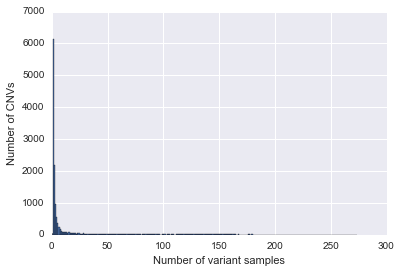

In [6]:
report.NVARIANT.hist(bins=range(275))
plt.ylabel('Number of CNVs')
plt.xlabel('Number of variant samples');

In [7]:
def get_genomestrip_vcf_copy_number_states(vcf):
    """Parse a genomestrip VCF file and get the diploid copy number states
    for each sample."""
    f = open(vcf)
    line = f.readline()
    while line[0:2] == '##':
        line = f.readline()
    header = line[1:].strip().split('\t')

    ind = []
    copy_numbers = []
    line = f.readline().strip()
    while line != '':
        t = line.split('\t')
        ind.append(t[2])
        copy_numbers.append([int(x.split(':')[1]) for x in t[9:]])
        line = f.readline().strip()
    cns = pd.DataFrame(copy_numbers, index=ind, columns=header[9:])
    return cns

def annotate_genomestrip_cnvs(
    report, 
    cns,
    transcript_to_gene=cpy.gencode_transcript_gene,
    add_chr=True,
):
    report = pd.read_table(report, index_col=0)
    cnv_info = pd.DataFrame([x.split('_')[1:] for x in report.index], 
                            index=cns.index, columns=['chrom', 'start', 'end'])
    if add_chr:
        cnv_info['chrom'] = 'chr' + cnv_info.chrom
    cnv_info['start'] = cnv_info.start.astype(int)
    cnv_info['end'] = cnv_info.end.astype(int)
    cnv_info['length'] = cnv_info.end - cnv_info.start
    cnv_info['name'] = cnv_info.index

    s = '\n'.join(cnv_info.chrom + '\t' + cnv_info.start.astype(str) + 
                  '\t' + cnv_info.end.astype(str) + '\t' + cnv_info.name) + '\n'
    cnv_bt = pbt.BedTool(s, from_string=True)
    cnv_bt = cnv_bt.sort()
    
    # Find genes that the CNV overlaps.
    res = cnv_bt.intersect(genes, sorted=True, wo=True)
    df = res.to_dataframe()
    df['gene'] = df.thickEnd
    gb = df[['name', 'gene']].groupby('name')
    se = pd.Series(dict(list(gb['gene'])))
    cnv_info['overlaps_gene'] = se.apply(lambda x: set(x))

    # Find genes that the CNV contains completely.
    df = df[df.blockSizes == df.thickStart - df.strand]
    gb = df[['name', 'gene']].groupby('name')
    se = pd.Series(dict(list(gb['gene'])))
    cnv_info['contains_gene'] = se.apply(lambda x: set(x))  

    # Annotate with genes where the CNV overlaps exonic regions.
    tg = pd.read_table(transcript_to_gene, index_col=0, header=None, squeeze=True)
    res = cnv_bt.intersect(exons, sorted=True, wo=True)
    df = res.to_dataframe()
    df['gene'] = df.thickEnd.apply(lambda x: tg[x])
    gb = df[['name', 'gene']].groupby('name')
    se = pd.Series(dict(list(gb['gene'])))
    cnv_info['overlaps_gene_exon'] = se.apply(lambda x: set(x))    

    # Distance to nearest TSS.
    res = cnv_bt.closest(tss_bt, D='b')
    df = res.to_dataframe()
    cnv_info.ix[df.name, 'nearest_tss_dist'] = df.thickEnd.values
    
    cnv_info = cnv_info.join(report)
    mode = cns.mode(axis=1)[0]
    cnv_info['cn_mode'] = mode
    nvariant = [sum(cns.ix[i] != cnv_info.ix[i, 'cn_mode']) for i in cnv_info.index]
    cnv_info['diff_from_mode'] = nvariant
    cnv_info['percent_diff_from_mode'] = cnv_info.diff_from_mode / cns.shape[1]
    
    t = cns[unr_rna_meta.wgs_id]
    nvariant = [sum(t.ix[i] != cnv_info.ix[i, 'cn_mode']) for i in cnv_info.index]
    cnv_info['unrelated_diff_from_mode'] = nvariant
    cnv_info['unrelated_percent_diff_from_mode'] = cnv_info.unrelated_diff_from_mode / unr_rna_meta.shape[0]
    rna_meta_eqtl = rna_meta[rna_meta.in_eqtl]
    vc = rna_meta_eqtl.family_id.value_counts()
    vc = vc[vc > 4]
    for x in vc.index:
        t = cns[rna_meta_eqtl.ix[rna_meta_eqtl.family_id == x, 'wgs_id']]
        pvariant = [sum(t.ix[i] != cnv_info.ix[i, 'cn_mode']) for i in cnv_info.index]
        cnv_info['{}_{}_diff_from_mode'.format(x, vc[x])] = np.array(pvariant)
        cnv_info['{}_{}_percent_diff_from_mode'.format(x, vc[x])] = np.array(pvariant) / float(vc[x])
    family_cols = ['{}_{}_percent_diff_from_mode'.format(x, vc[x]) for x in vc.index]    
    return cnv_info, cnv_bt

In [8]:
out = os.path.join(private_outdir, 'gs_genotypes.tsv')
if not os.path.exists(out):
    fn = '/projects/CARDIPS/pipeline/WGS/BF_GS_Discovery/gs_cnv.genotypes.vcf'
    gs_cns = get_genomestrip_vcf_copy_number_states(fn)
    gs_cns.to_csv(out, sep='\t')
else:
    gs_cns = pd.read_table(out, index_col=0)

In [9]:
out = os.path.join(outdir, 'gs_info.pickle')
if not os.path.exists(out):
    fn = '/projects/CARDIPS/pipeline/WGS/BF_GS_Discovery/eval/CopyNumberClass.report.dat'
    gs_info, gs_bt = annotate_genomestrip_cnvs(fn, gs_cns)
    gs_bt.saveas(os.path.join(outdir, 'gs_cnvs.bed'), trackline="track type=bed name='GenomeStrip CNVs'")
    if not os.path.exists('/home/cdeboever/public_html/gs_cnvs.bed'):
        os.symlink(os.path.join(outdir, 'gs_cnvs.bed'), '/home/cdeboever/public_html/gs_cnvs.bed')
    cPickle.dump(gs_info, open(out, 'w'))
else:
    gs_info = cPickle.load(open(out))
    gs_bt = pbt.BedTool(os.path.join(outdir, 'gs_cnvs.bed'))

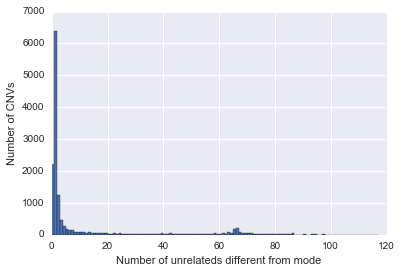

In [10]:
gs_info.unrelated_diff_from_mode.hist(bins=range(118))
plt.xlabel('Number of unrelateds different from mode')
plt.ylabel('Number of CNVs');

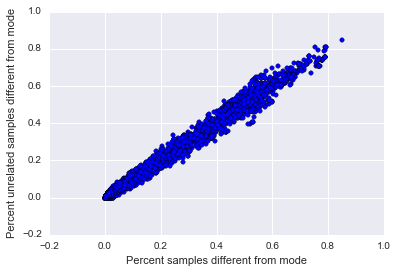

In [11]:
p1 = gs_info.percent_diff_from_mode
p2 = gs_info.unrelated_percent_diff_from_mode
diff = p1 - p2
diff.sort_values(inplace=True)
plt.scatter(p1, p2)
plt.xlabel('Percent samples different from mode')
plt.ylabel('Percent unrelated samples different from mode');

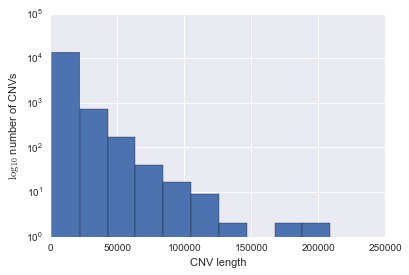

In [12]:
gs_info.length.hist(log=True)
plt.ylabel('$\log_{10}$ number of CNVs')
plt.xlabel('CNV length');

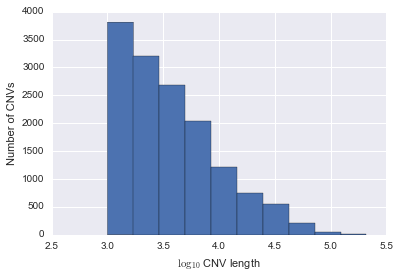

In [13]:
(np.log10(gs_info.length)).hist()
plt.ylabel('Number of CNVs')
plt.xlabel('$\log_{10}$ CNV length');

In [14]:
gs_info.length.describe()

count     14500.000000
mean       6615.005931
std       10552.781125
min         999.000000
25%        1660.000000
50%        3049.000000
75%        6574.250000
max      208946.000000
Name: length, dtype: float64

In [15]:
cutoffs = np.array([2, 5, 10, 50, 100, 200]) * 1000
for c in cutoffs:
    print('{:.1f}% of CNVs are less than {:,} bp'.format(
            100 * sum(gs_info.length < c) / float(gs_info.shape[0]), c))

32.7% of CNVs are less than 2,000 bp
67.2% of CNVs are less than 5,000 bp
84.1% of CNVs are less than 10,000 bp
99.0% of CNVs are less than 50,000 bp
99.9% of CNVs are less than 100,000 bp
100.0% of CNVs are less than 200,000 bp


In [16]:
gs_info.length.median()

3049.0

In [17]:
gs_info.CNCATEGORY.value_counts()

DEL      9791
DUP      2645
MIXED    2064
Name: CNCATEGORY, dtype: int64

In [18]:
print(gs_info[gs_info.CNCATEGORY == 'DEL'].length.median())
print(gs_info[gs_info.CNCATEGORY == 'DUP'].length.median())
print(gs_info[gs_info.CNCATEGORY == 'MIXED'].length.median())

2620.0
7574.0
2250.5


### Merge CNVs

I want to merge adjacent CNVs that have highly correlated copy number estimates. These
are likely just one CNV that GS has split into more than one. 

For instance, the heatmap below shows the copy number correlation for the first 100 CNVs
on chr1. We can see some blocks of red. These are adjacent CNVs that have highly correlated
copy numbers. I think these should be merged into single larger CNVs.

In [19]:
# Add order so we can check whether CNVs are adjacent.
gs_info.sort_values(by=['chrom', 'start', 'end'], inplace=True)
gs_info['order'] = range(gs_info.shape[0])

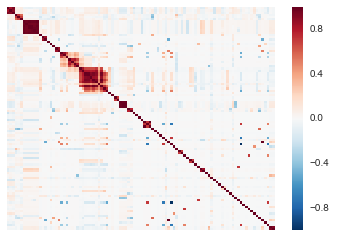

In [20]:
t = gs_info[gs_info.chrom == 'chr1'].head(100)
corr = gs_cns.ix[t.index].T.corr()
sns.heatmap(corr, xticklabels=[], yticklabels=[]);

I will merge chromosome by chromosome as follows:

* Calculate genotype correlation matrix for all CNVs on the chromosome
* Create graph where nodes are CNVs and an edge exists between two CNVs if
their copy number estimates are correlated > 0.9.
* For each connected component with more than one CNV, we sort the CNVs by position and 
look at each pair of adjacent CNVs and determine whether the two should be merged. We merge 
if the two CNVs are adjacent amongst all the calls (not just the connected component) and
if the average difference in their copy number estimates is less than 0.5. 
* Once we know which pairs should be merged, we merge all CNVs at once. For instance, let's 
say we have five CNVs $[c_1, c_2, c_3, c_4, c_5]$. We will perform 4 pairwise comparisons.
We compare $c_1$ and $c_2$ and decide they should
be combined. We similarly decide $c_2$ and $c_3$ should be merged. However, $c_3$ and $c_4$ should
not be merged, but $c_4$ and $c_5$ should. After we've done the comparisons, we merge all of $c_1$,
$c_2$, and $c_3$ at once, then we separately merge $c_4$ and $c_5$.

In [21]:
def combine_connected_component(cnvs, info, cns):
    """
    If appropriate, combine CNVs from the list cnvs. The CNVs in cnvs should
    have highly correlated genotypes (for instance, cnvs might be a list of connected
    nodes from a graph built from the genotype correlations).
    
    Parameters
    ----------
    cnvs : list
        List of CNVs of the form CNV_2_400_800 (aka CNV_{chrom}_{start}_{end}).
        
    info : pandas.DataFrame
        Data frame whose index contains the values in cnvs. This dataframe should at least
        have chrom, start, and end columns.
        
    cns : pandas.DataFrame
        Data frame whose index contains the values in cnvs. This data frame should contain
        the diploid copy number estimates.
    
    """
    cnvs = sorted(cnvs)
    out = dict()
    combine = []
    for i in range(len(cnvs) - 1):
        combine.append((abs(info.ix[cnvs[i], 'order'] - info.ix[cnvs[i + 1], 'order']) == 1) and
                       ((cns.ix[cnvs[i]] - cns.ix[cnvs[i + 1]]).abs().mean() < 0.5))
    i = 0
    to_combine = [cnvs[0]]
    while i < len(cnvs) - 1:
        if combine[i]:
            to_combine.append(cnvs[i + 1])
        else:
            if len(to_combine) > 1:
                out[combine_cnvs(to_combine, gs_info)] = to_combine
            to_combine = [cnvs[i + 1]]
        i += 1
    if len(to_combine) > 1:
        out[combine_cnvs(to_combine, gs_info)] = to_combine
    return out

def combine_cnvs(cnvs, info):
    """Combine the list of CNVs cnvs into a single CNV of form CNV_{chrom}_{start}_{end}."""
    return 'CNV_{}_{}_{}'.format(info.ix[cnvs[0], 'chrom'][3:], 
                                 info.ix[cnvs, 'start'].min(), 
                                 info.ix[cnvs, 'end'].max())

def merge_cnvs(a, b, info, cns):
    """Return boolean indicating whether CNVs a and b should be merged."""
    return ((abs(info.ix[a, 'order'] - info.ix[b, 'order']) == 1) and
            ((cns.ix[a] - cns.ix[b]).abs().mean() < 0.5))

In [22]:
combined = dict()
# We'll go through one chromosome at a time. 
for chrom in set(gs_info.chrom):
    t = gs_info[gs_info.chrom == chrom]
    corr = gs_cns.ix[t.index].T.corr()
    g = corr > 0.9
    edges = []
    for i in g.columns:
        se = g[i]
        se = se[se]
        for j in se.index:
            edges.append((i, j))
    g = nx.Graph(edges)
    cc = nx.connected_components(g)
    while True:
        try:
            c = list(cc.next())
            if len(c) > 1:
                d = combine_connected_component(c, gs_info, gs_cns)
                for k in d.keys():
                    combined[k] = d[k]
        except StopIteration:
            break

In [23]:
mapping_from = []
mapping_to = []
for k in combined.keys():
    for x in combined[k]:
        mapping_from.append(x)
        mapping_to.append(k)
mapping = pd.Series(mapping_to, index=mapping_from)
mapping.to_csv(os.path.join(outdir, 'combined_mapping.tsv'), sep='\t')

In [24]:
to_remove = []
new_genotypes = []
for k in combined.keys():
    to_remove += combined[k]
    new_genotypes.append(gs_cns.ix[combined[k]].mean())
print('{} CNVs combined into {} CNVs.'.format(len(to_remove), len(combined)))

4533 CNVs combined into 920 CNVs.


In [25]:
new_genotypes = pd.DataFrame(new_genotypes, index=combined.keys())
gs_combined_cns = pd.concat([gs_cns.drop(to_remove), new_genotypes])
fn = os.path.join(private_outdir, 'gs_combined_genotypes.tsv')
gs_combined_cns.to_csv(fn, index_col=0)

In [26]:
def annotate_merged_genomestrip_cnvs(
    cnv_info, 
    cns,
    transcript_to_gene=cpy.gencode_transcript_gene,
    add_chr=True,
):
    if add_chr:
        cnv_info['chrom'] = 'chr' + cnv_info.chrom
    cnv_info['start'] = cnv_info.start.astype(int)
    cnv_info['end'] = cnv_info.end.astype(int)
    cnv_info['length'] = cnv_info.end - cnv_info.start
    cnv_info['name'] = cnv_info.index

    s = '\n'.join(cnv_info.chrom + '\t' + cnv_info.start.astype(str) + 
                  '\t' + cnv_info.end.astype(str) + '\t' + cnv_info.name) + '\n'
    cnv_bt = pbt.BedTool(s, from_string=True)
    cnv_bt = cnv_bt.sort()
    
    # Find genes that the CNV overlaps.
    res = cnv_bt.intersect(genes, sorted=True, wo=True)
    df = res.to_dataframe()
    df['gene'] = df.thickEnd
    gb = df[['name', 'gene']].groupby('name')
    se = pd.Series(dict(list(gb['gene'])))
    cnv_info['overlaps_gene'] = se.apply(lambda x: set(x))

    # Find genes that the CNV contains completely.
    df = df[df.blockSizes == df.thickStart - df.strand]
    gb = df[['name', 'gene']].groupby('name')
    se = pd.Series(dict(list(gb['gene'])))
    cnv_info['contains_gene'] = se.apply(lambda x: set(x))  

    # Annotate with genes where the CNV overlaps exonic regions.
    tg = pd.read_table(transcript_to_gene, index_col=0, header=None, squeeze=True)
    res = cnv_bt.intersect(exons, sorted=True, wo=True)
    df = res.to_dataframe()
    df['gene'] = df.thickEnd.apply(lambda x: tg[x])
    gb = df[['name', 'gene']].groupby('name')
    se = pd.Series(dict(list(gb['gene'])))
    cnv_info['overlaps_gene_exon'] = se.apply(lambda x: set(x))    

    # Distance to nearest TSS.
    res = cnv_bt.closest(tss_bt, D='b')
    df = res.to_dataframe()
    cnv_info.ix[df.name, 'nearest_tss_dist'] = df.thickEnd.values
    
    mode = cns.mode(axis=1)[0]
    cnv_info['cn_mode'] = mode
    nvariant = [sum(cns.ix[i] != cnv_info.ix[i, 'cn_mode']) for i in cnv_info.index]
    cnv_info['diff_from_mode'] = nvariant
    cnv_info['percent_diff_from_mode'] = cnv_info.diff_from_mode / cns.shape[1]
    
    t = cns[unr_rna_meta.wgs_id]
    nvariant = [sum(t.ix[i] != cnv_info.ix[i, 'cn_mode']) for i in cnv_info.index]
    cnv_info['unrelated_diff_from_mode'] = nvariant
    cnv_info['unrelated_percent_diff_from_mode'] = cnv_info.unrelated_diff_from_mode / unr_rna_meta.shape[0]
    rna_meta_eqtl = rna_meta[rna_meta.in_eqtl]
    vc = rna_meta_eqtl.family_id.value_counts()
    vc = vc[vc > 4]
    for x in vc.index:
        t = cns[rna_meta_eqtl.ix[rna_meta_eqtl.family_id == x, 'wgs_id']]
        pvariant = [sum(t.ix[i] != cnv_info.ix[i, 'cn_mode']) for i in cnv_info.index]
        cnv_info['{}_{}_diff_from_mode'.format(x, vc[x])] = np.array(pvariant)
        cnv_info['{}_{}_percent_diff_from_mode'.format(x, vc[x])] = np.array(pvariant) / float(vc[x])
    family_cols = ['{}_{}_percent_diff_from_mode'.format(x, vc[x]) for x in vc.index]    
    return cnv_info, cnv_bt

In [27]:
tdf = pd.DataFrame([x.split('_') for x in combined.keys()], columns=['cnv', 'chrom', 'start', 'end'],
                   index=combined.keys()).drop('cnv', axis=1)
tdf.start = tdf.start.astype(int)
tdf.end = tdf.end.astype(int)
a,b = annotate_merged_genomestrip_cnvs(tdf, new_genotypes)
gs_combined_info = pd.concat([a, gs_info.drop(to_remove)])
fn = os.path.join(outdir, 'gs_combined_info.pickle')
gs_combined_info.to_pickle(fn)

### Functional annotations

I'm going to annotate the CNVs with more info.

In [28]:
def cnv_counts(cnv_bt, cnv_info, url, name):
    bt = pbt.BedTool(cpb.general.read_gzipped_text_url(url), from_string=True)
    bt = bt.sort()
    res = cnv_bt.intersect(bt, sorted=True, wo=True)
    r = res[0]
    df = res.to_dataframe(names=range(len(res[0].fields)))
    vc = df[3].value_counts()
    counts = pd.DataFrame(0, columns=[name], index=cnv_info.index)
    counts.ix[vc.index, name] = vc
    return counts

def cluster_setup():
    from ipyparallel import Client
    parallel_client = Client(profile='parallel')
    dview = parallel_client[:]
    print('Cluster has {} engines.'.format(len(parallel_client.ids)))
    with dview.sync_imports():
        import cdpybio
        import pandas
        import pybedtools
    %px cpb = cdpybio
    %px pd = pandas
    %px pbt = pybedtools
    dview.push(dict(cnv_counts=cnv_counts));
    dview.push(dict(gs_bt=gs_bt));
    return dview

cluster_ready = False

#### Roadmap DNase and ChIP-seq

In [34]:
out = os.path.join(outdir, 'gs_roadmap_overlap.tsv')
if not os.path.exists(out):
    url = ('http://egg2.wustl.edu/roadmap/data/byFileType'
           '/peaks/consolidated/narrowPeak/')
    website = urllib2.urlopen(url)
    html = website.read()
    files = re.findall('href="(.*\.gz)"', html)
    lines = [x for x in roadmap_ids.index if ('ES' in roadmap_ids[x] and 'Cultured' not in roadmap_ids[x])]
    lines += [x for x in roadmap_ids.index if 'iPS' in roadmap_ids[x]]
    files = [x for x in files if x.split('-')[0] in lines]
    files = [x for x in files if 'hotspot' not in x]

    roadmap_peak_pvals = pd.DataFrame(
        -1, index=lines, 
        columns=set([x.split('-')[1].split('.')[0] for x in files]))
    roadmap_peak_oddsratios = pd.DataFrame(
        0, index=lines, 
        columns=set([x.split('-')[1].split('.')[0] for x in files]))

    urls = ['http://egg2.wustl.edu/roadmap/data/byFileType/peaks/consolidated/narrowPeak/{}'.format(n)
            for n in files]
    lines = [roadmap_ids[re.findall('E\d{3}', url)[0]][0:-10].replace(' ', '_') for url in urls]
    btype = [re.findall('-(.+)\.', url)[0].split('.')[0] for url in urls]
    names = ['{}_{}'.format(lines[i], btype[i]) for i in range(len(lines))]
    todo = zip(urls, names)
    if cluster_ready == False:
        dview = cluster_setup()
        cluster_ready = True
    counts = dview.map_sync(lambda x: cnv_counts(gs_bt, gs_info, x[0], x[1]), todo)
    roadmap_dnase_counts = pd.concat(counts, axis=1)
    roadmap_dnase_counts.to_csv(out, sep='\t')
else:
    roadmap_dnase_counts = pd.read_table(out, index_col=0)

#### Roadmap chromatin state

#### ENCODE DNase

In [36]:
out = os.path.join(outdir, 'gs_encode_dnase_overlap.tsv')
if not os.path.exists(out):
    encode_dnase = pd.read_table(os.path.join(ciepy.root, 'output', 
                                              'functional_annotation_analysis', 
                                              'encode_dnase.tsv'), index_col=0)
    encode_dnase = encode_dnase[encode_dnase.biosample_type == 'stem cell']
    encode_dnase['name'] = encode_dnase.cell_type + '_' + 'DNase'
    if cluster_ready == False:
        dview = cluster_setup()
        cluster_ready = True
    dview.push(dict(encode_dnase=encode_dnase));
    counts = dview.map_sync(lambda i: cnv_counts(gs_bt, gs_info, 
                                                 encode_dnase.ix[i, 'narrowPeak_url'], 
                                                 encode_dnase.ix[i, 'name']), 
                            encode_dnase.index)
    encode_dnase_counts = pd.concat(counts, axis=1)
    encode_dnase_counts.to_csv(out, sep='\t')
else:
    encode_dnase_counts = pd.read_table(out, index_col=0)

#### ENCODE ChIP-seq

In [37]:
out = os.path.join(outdir, 'gs_encode_tf_chip_seq_overlap.tsv')
if not os.path.exists(out):
    encode_tf_chip_seq = pd.read_table(os.path.join(ciepy.root, 'output', 
                                                    'functional_annotation_analysis', 
                                                    'encode_stem_cell_chip_seq.tsv'), index_col=0)
    encode_tf_chip_seq = encode_tf_chip_seq.drop_duplicates(subset='target')
    encode_tf_chip_seq['name'] = encode_tf_chip_seq.cell_type + '-' + encode_tf_chip_seq.target
    if cluster_ready == False:
        dview = cluster_setup()
        cluster_ready = True
    dview.push(dict(encode_tf_chip_seq=encode_tf_chip_seq));
    counts = dview.map_sync(lambda i: cnv_counts(gs_bt, gs_info,
                                                 encode_tf_chip_seq.ix[i, 'narrowPeak_url'], 
                                                 encode_tf_chip_seq.ix[i, 'name']), 
                            encode_tf_chip_seq.index)
    encode_tf_chip_seq_counts = pd.concat(counts, axis=1)
    encode_tf_chip_seq_counts.to_csv(out, sep='\t')
else:
    encode_tf_chip_seq_counts = pd.read_table(out, index_col=0)

## EMMAX CNVs

I want to find CNVs that I can include in the EMMAX association analysis. 

### GenomeStrip

For GS, I can use CNVs that have at most three copy number states and have a
minor allele frequency greater than 1% (aka at least 1% of samples differ from 
the mode copy number state). I can also separately test mCNVs for an association 
with gene expression.

In [38]:
# Get copy number states for samples in eQTL analysis.
cns_f = gs_cns[rna_meta[rna_meta.in_eqtl].wgs_id]
# Get the number of distinct copy number states for each CNV.
num_states = cns_f.apply(lambda x: len(set(x)), axis=1)
# Keep CNVs with two or three states.
cns_emmax = cns_f.ix[num_states[num_states.apply(lambda x: x in [2, 3])].index]
# Remove CNVs where less than 1% of the samples are different from the mode.
b = (cns_emmax.apply(lambda x: x.value_counts().max() < 
                     cns_emmax.shape[1] - np.floor(rna_meta.in_eqtl.sum() * 0.01), axis=1))
cns_emmax = cns_emmax[b]

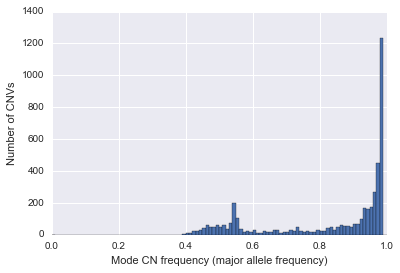

In [39]:
maj_af = cns_emmax.apply(lambda x: x.value_counts().max(), axis=1) / cns_emmax.shape[1]
maj_af.hist(bins=np.arange(0, 1.01, 0.01))
plt.ylabel('Number of CNVs')
plt.xlabel('Mode CN frequency (major allele frequency)');

In [40]:
t = gs_info.ix[cns_emmax.index]
s = '\n'.join(t.chrom + '\t' + t.start.astype(str) + '\t' + t.end.astype(str) + 
              '\t' + t.name) + '\n'
cns_emmax_bt = pbt.BedTool(s, from_string=True)
cns_emmax_bt = cns_emmax_bt.sort()

fn = os.path.join(ciepy.root, 'output', 'eqtl_input', 'variant_regions.bed')
variant_regions = pbt.BedTool(fn)
genes_todo = set(exp.index)

res = cns_emmax_bt.intersect(variant_regions, sorted=True, wo=True)
g = []
for r in res:
    g.append(r.fields[-3].split('_')[0])
cnv_gene_vc = pd.Series(g).value_counts()
cnv_gene_vc = cnv_gene_vc[set(cnv_gene_vc.index) & genes_todo]

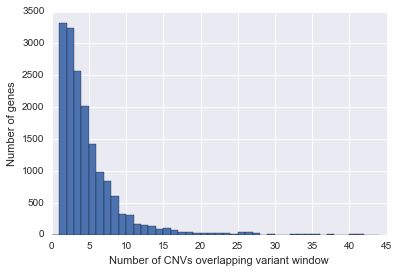

In [41]:
cnv_gene_vc.hist(bins=range(cnv_gene_vc.max()))
plt.ylabel('Number of genes')
plt.xlabel('Number of CNVs overlapping variant window');

I think that I can collapse some mCNVs to be biallelic. For instance, the CNV
below has one person with copy number 4, but if we exclude that person, we would
only have three copy number states. The person who is four is likely just an error and
should actually be 3, or at the least it wouldn't hurt to make them copy number 3 or 
just not include them in the analysis.

In [42]:
report.ix['CNV_19_40372246_40375846']

CALLRATE               0.989
CNMIN                      1
CNMAX                      4
CNALLELES                  3
NNONREF                  140
NVARIANT                 140
CNCATEGORY             MIXED
CNDIST        0,109,131,30,1
Name: CNV_19_40372246_40375846, dtype: object

In [43]:
t = cns_f.ix[set(cns_f.index) - set(cns_emmax.index)]
t = t[t.apply(lambda x: len(set(x)) > 3, axis=1)]
# b has the number of samples that have one of the top three copy number states
b = t.apply(lambda x: x.value_counts()[0:3].sum(), axis=1)

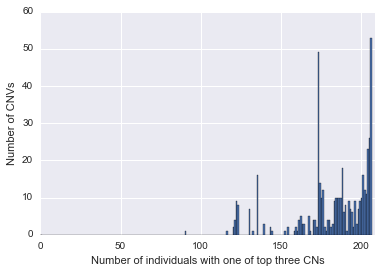

In [44]:
b.hist(bins=range(208))
plt.xlim(0, 209)
plt.ylabel('Number of CNVs')
plt.xlabel('Number of individuals with one of top three CNs');

This plot shows us that many CNVs are almost biallelic. If we remove 
a few samples, we can make more sites biallelic.

In [45]:
sum(b >= rna_meta.in_eqtl.sum() * 0.95)

807

There are 807 CNVs for which I can remove people with rare copy numbers
and still have 95% call rate. I'll set the rare copy numbers to missing
and include these.

In [46]:
rows = []
for i in b[b >= rna_meta.in_eqtl.sum() * 0.95].index:
    se = cns_f.ix[i]
    vc = se.value_counts()
    se[se.apply(lambda x: x not in vc.index[0:3])] = np.nan
    rows.append(se)
df = pd.DataFrame(rows, index=b[b >= rna_meta.in_eqtl.sum() * 0.95].index, 
                  columns=cns_f.columns)

In [47]:
b = df.apply(lambda x: x.value_counts().max() < df.shape[1] - np.floor(rna_meta.in_eqtl.sum() * 0.05), axis=1)
df = df[b]

In [48]:
cns_emmax = pd.concat([cns_emmax, df])
cns_emmax.to_csv(os.path.join(private_outdir, 'gs_emmax_cnvs.tsv'), sep='\t')

In [49]:
cns_emmax.shape

(5348, 215)

I want to remove CNV in the MHC region because these are likely alignment artifacts.
[`Bioinformatics and Functional Genomics` by Jonathan Pevsner](https://books.google.com/books?id=FKRjCgAAQBAJ&pg=PA50&lpg=PA50&dq=ucsc+genome+browser+mhc&source=bl&ots=6i7JYq_oA5&sig=DlZM3EvEmc5G4hLSK-0haSDz7vM&hl=en&sa=X&ved=0ahUKEwid0auysI_LAhXKLyYKHZkqD1YQ6AEIRjAH#v=onepage&q=ucsc%20genome%20browser%20mhc&f=false) 
says the MHC is ~29.6 to 33.1 mb on chromosome 6 so I'll use that.

In [50]:
t = gs_info.ix[cns_emmax.index]
s = '\n'.join(t.chrom + '\t' + t.start.astype(str) + '\t' + t.end.astype(str) + 
              '\t' + t.name) + '\n'
cns_emmax_bt = pbt.BedTool(s, from_string=True)
cns_emmax_bt = cns_emmax_bt.sort()
res = cns_emmax_bt.intersect(mhc_bt, wa=True, v=True)
df = res.to_dataframe()
cns_emmax = cns_emmax.ix[df.name]

In [51]:
cns_emmax.shape

(5287, 215)

I'll write a VCF file with the CNV genotypes.

In [52]:
cns_emmax_genotypes = cns_emmax.copy(deep=True).astype(str)
mins = cns_emmax.apply(lambda x: x == x.min(), axis=1)
maxs = cns_emmax.apply(lambda x: x == x.max(), axis=1)
nulls = cns_emmax.isnull()
hets = (mins.astype(int) + maxs.astype(int) + nulls.astype(int) == 0)
cns_emmax_genotypes[mins] = '0/0'
cns_emmax_genotypes[hets] = '0/1'
cns_emmax_genotypes[maxs] = '1/1'
cns_emmax_genotypes[nulls] = './.'

In [53]:
cns_emmax_info = gs_info.ix[cns_emmax.index, ['chrom', 'start']]
cns_emmax_info.chrom = cns_emmax_info.chrom.apply(lambda x: x[3:])
#cns_emmax_info = cns_emmax_info.drop(['end', 'length'], axis=1)
cns_emmax_info.start = cns_emmax_info.start.astype(str)
cns_emmax_info['id'] = cns_emmax_info.index
cns_emmax_info['ref'] = 'N'
cns_emmax_info['alt'] = 'N'
cns_emmax_info['qual'] = '100000'
cns_emmax_info['filter'] = 'PASS'
cns_emmax_info['info'] = ''
cns_emmax_info['format'] = 'GT'
cns_emmax_info = cns_emmax_info.join(cns_emmax_genotypes[sorted(cns_emmax_genotypes.columns)])

In [54]:
with open('/projects/CARDIPS/analysis/cardips-ipsc-eqtl/misc/header.vcf') as f:
    lines = f.readlines()
vs = lines[-1].strip().split('\t')[9:]
colnames = lines[-1].strip().split('\t')[0:9]

In [55]:
out = os.path.join(private_outdir, 'gs_emmax_sorted.vcf')
if not os.path.exists(out):
    with open(os.path.join(private_outdir, 'gs_emmax.vcf'), 'w') as f:
        f.write(''.join(lines[0:-1]))
        f.write('\t'.join(colnames + list(cns_emmax_info.columns[9:])) + '\n')
        f.write('\n'.join(cns_emmax_info.apply(lambda x: '\t'.join(x), axis=1)) + '\n')
    !cat {os.path.join(private_outdir, 'gs_emmax.vcf')} | vcf-sort > {out}
    !bgzip {out}
    !bcftools index -f {out}.gz
    !bcftools index -f -t {out}.gz
    !rm {os.path.join(private_outdir, 'gs_emmax.vcf')}

Let's see which genes have CNVs to test now that we've added in some more CNVs.

In [56]:
t = gs_info.ix[cns_emmax.index]
s = '\n'.join(t.chrom + '\t' + t.start.astype(str) + '\t' + t.end.astype(str) + 
              '\t' + t.name) + '\n'
cns_emmax_bt = pbt.BedTool(s, from_string=True)
cns_emmax_bt = cns_emmax_bt.sort()

res = cns_emmax_bt.intersect(variant_regions, sorted=True, wo=True)
g = []
for r in res:
    g.append(r.fields[-3].split('_')[0])
cnv_gene_vc = pd.Series(g).value_counts()
cnv_gene_vc = cnv_gene_vc[set(cnv_gene_vc.index) & genes_todo]

In [57]:
t = gs_info.ix[cns_emmax.index]
s = '\n'.join(t.chrom + '\t' + t.start.astype(str) + '\t' + t.end.astype(str) + 
              '\t' + t.name) + '\n'
cns_emmax_bt = pbt.BedTool(s, from_string=True)
cns_emmax_bt = cns_emmax_bt.sort()

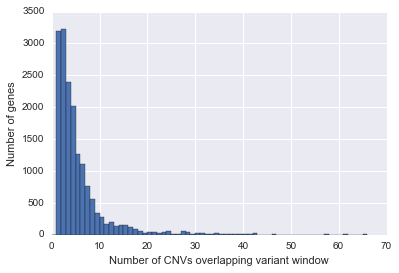

In [58]:
cnv_gene_vc.hist(bins=range(cnv_gene_vc.max()))
plt.ylabel('Number of genes')
plt.xlabel('Number of CNVs overlapping variant window');

### Lumpy

In [59]:
def read_merged_lumpy_vcf(fn):
    """Read and parse a merged VCF of lumpy results."""
    df = pd.read_table(fn, skiprows=641, low_memory=False)
    df.columns = [x.replace('#', '') for x in df.columns]
    df = df[df.ALT.apply(lambda x: x in ['<DEL>', '<DUP>'])]
    gcols = df.columns[8:]
    genotypes = df[gcols]
    genotypes = genotypes.apply(lambda x: [y.split(':')[0] for y in x], axis=1)
    df = df.drop(gcols, axis=1)
    cols = [x.split('=')[0] for x in df.INFO[0].split(';')]
    imprecise = []
    rows = []
    for i in df.index:
        vals = list(df.ix[i, 'INFO'].split(';'))
        if 'IMPRECISE' in vals:
            imprecise.append(True)
            vals.remove('IMPRECISE')
        else:
            imprecise.append(False)
        rows.append(dict([x.split('=') for x in vals]))
    df['imprecise'] = imprecise
    tdf = pd.DataFrame(rows, index=df.index)
    df = df.join(tdf)
    df = df.drop('INFO', axis=1)
    df.CHROM = 'chr' + df.CHROM.astype(str)
    # cols = df.FORMAT[0].split(':')
    # ds = df.apply(lambda x: pd.Series(dict(zip(x['FORMAT'].split(':'), x[df.columns[8]].split(':')))), axis=1)
    # ds = ds.drop(set(df.columns) & set(ds.columns), axis=1)
    # df = df.join(ds)
    # df = df.drop(['FORMAT', df.columns[8]], axis=1)
    df.ALT = df.ALT.apply(lambda x: x[1:4])
    df = df[df.END.isnull() == False]
    for c in ['POS', 'END', 'PE', 'SR', 'SU', 'SVLEN']:
        df[c] = df[c].astype(int)
    return df, genotypes

In [60]:
fn = '/frazer01/home/djakubosky/sandbox/svtools/Lumpy_274_Merged.vcf'
lumpy_info, lumpy_genotypes = read_merged_lumpy_vcf(fn)
lumpy_info['name'] = (lumpy_info.ALT + '_' + lumpy_info.CHROM.apply(lambda x: x[3:]) + 
                      '_' + lumpy_info.POS.astype(str) + '_' + lumpy_info.END.astype(str))
# Some lumpy SVs show up multiple times in the VCF (not sure why) so I'll just keep one.
lumpy_info = lumpy_info.drop_duplicates(subset=['name'])
lumpy_genotypes = lumpy_genotypes.ix[lumpy_info.index]
lumpy_info.index = lumpy_info.name
lumpy_genotypes.index = lumpy_info.name

In [61]:
s = '\n'.join(lumpy_info.CHROM + '\t' + lumpy_info.POS.astype(str) + '\t' + 
              lumpy_info.END.astype(str) + '\t' + lumpy_info.name) + '\n'
lumpy_bt = pbt.BedTool(s, from_string=True).sort()

In [62]:
# Find genes that the CNV overlaps.
res = lumpy_bt.intersect(genes, sorted=True, wo=True)
df = res.to_dataframe()
df['gene'] = df.thickEnd
gb = df[['name', 'gene']].groupby('name')
se = pd.Series(dict(list(gb['gene'])))
lumpy_info['overlaps_gene'] = se.apply(lambda x: set(x))

# Find genes that the CNV contains completely.
df = df[df.blockSizes == df.thickStart - df.strand]
gb = df[['name', 'gene']].groupby('name')
se = pd.Series(dict(list(gb['gene'])))
lumpy_info['contains_gene'] = se.apply(lambda x: set(x))  

# Annotate with genes where the CNV overlaps exonic regions.
tg = pd.read_table(cpy.gencode_transcript_gene, index_col=0, header=None, squeeze=True)
res = lumpy_bt.intersect(exons, sorted=True, wo=True)
df = res.to_dataframe()
df['gene'] = df.thickEnd.apply(lambda x: tg[x])
gb = df[['name', 'gene']].groupby('name')
se = pd.Series(dict(list(gb['gene'])))
lumpy_info['overlaps_gene_exon'] = se.apply(lambda x: set(x))    

# Distance to nearest TSS.
tss_bt = pbt.BedTool(tss_bed)
res = lumpy_bt.closest(tss_bt, D='b')
df = res.to_dataframe()
lumpy_info.ix[df.name, 'nearest_tss_dist'] = df.thickEnd.values

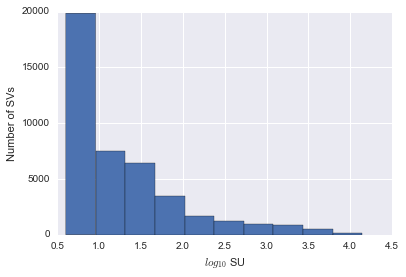

In [63]:
np.log10(lumpy_info.SU).hist()
plt.ylabel('Number of SVs')
plt.xlabel('$log_{10}$ SU');

In [64]:
lumpy_genotypes_f = lumpy_genotypes[rna_meta[rna_meta.in_eqtl].wgs_id]

In [65]:
lumpy_ref_ac = lumpy_genotypes_f.apply(lambda x: ''.join(x).count('0'), axis=1)
lumpy_alt_ac = lumpy_genotypes_f.apply(lambda x: ''.join(x).count('1'), axis=1)

lumpy_ref_af = lumpy_ref_ac.astype(float) / (lumpy_ref_ac + lumpy_alt_ac)
lumpy_alt_af = lumpy_alt_ac.astype(float) / (lumpy_ref_ac + lumpy_alt_ac)

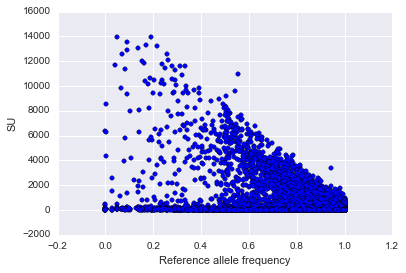

In [66]:
plt.scatter(lumpy_ref_af, lumpy_info.SU)
plt.ylabel('SU')
plt.xlabel('Reference allele frequency');

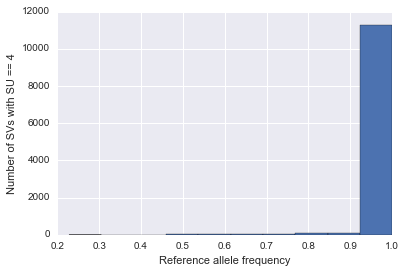

In [67]:
lumpy_ref_af[lumpy_info[lumpy_info.SU == 4].index].hist()
plt.xlabel('Reference allele frequency')
plt.ylabel('Number of SVs with SU == 4');

In [68]:
lumpy_af = pd.DataFrame({'ref':lumpy_ref_af, 'alt':lumpy_alt_af})
lumpy_af['maj_af'] = lumpy_af.max(axis=1)
lumpy_af['min_af'] = lumpy_af.min(axis=1)

In [69]:
n = lumpy_af[lumpy_af.min_af >= 0.01].shape[0]
print('{:,} lumpy SVs have minor allele frequency > 1%.'.format(n))

11,301 lumpy SVs have minor allele frequency > 1%.


I'll make a VCF file like I did for GS. I'll make them similarly formatted.

In [70]:
lumpy_keep = lumpy_af[lumpy_af.min_af >= 0.01].index

In [71]:
t = lumpy_info.ix[lumpy_keep]
s = '\n'.join(t.CHROM + '\t' + t.POS.astype(str) + '\t' + t.END.astype(str) + 
              '\t' + t.name) + '\n'
lumpy_emmax_bt = pbt.BedTool(s, from_string=True)
lumpy_emmax_bt = lumpy_emmax_bt.sort()
mhc_bt = pbt.BedTool('chr6\t{}\t{}'.format(int(29.6e6), int(33.1e6)), from_string=True)
res = lumpy_emmax_bt.intersect(mhc_bt, wa=True, v=True)
df = res.to_dataframe()
lumpy_keep = list(df.name)

In [72]:
lumpy_emmax_info = lumpy_info.ix[lumpy_keep, ['CHROM', 'POS','ID', 'REF', 'ALT', 'QUAL', 'FILTER', 'END']]
lumpy_emmax_info.CHROM = lumpy_emmax_info.CHROM.apply(lambda x: x[3:])
lumpy_emmax_info.ID = (lumpy_emmax_info.ALT + '_' + lumpy_emmax_info.CHROM + 
                       '_' + lumpy_emmax_info.POS.astype(str) + '_' + lumpy_emmax_info.END.astype(str))
lumpy_emmax_info.ALT = 'N'
lumpy_emmax_info.FILTER = 'PASS'
lumpy_emmax_info = lumpy_emmax_info.drop('END', axis=1)
lumpy_emmax_info['INFO'] = ''
lumpy_emmax_info['FORMAT'] = 'GT'
lumpy_emmax_info = lumpy_emmax_info.join(lumpy_genotypes_f[sorted(lumpy_genotypes_f.columns)])
lumpy_emmax_info = lumpy_emmax_info.astype(str)

In [73]:
with open('/projects/CARDIPS/analysis/cardips-ipsc-eqtl/misc/header.vcf') as f:
    lines = f.readlines()
vs = lines[-1].strip().split('\t')[9:]
colnames = lines[-1].strip().split('\t')[0:9]

In [74]:
out = os.path.join(private_outdir, 'lumpy_emmax_sorted.vcf')
if not os.path.exists(out):
    with open(os.path.join(private_outdir, 'lumpy_emmax.vcf'), 'w') as f:
        f.write(''.join(lines[0:-1]))
        f.write('\t'.join(colnames + list(lumpy_emmax_info.columns[9:])) + '\n')
        f.write('\n'.join(lumpy_emmax_info.apply(lambda x: '\t'.join(x), axis=1)) + '\n')
    !cat {os.path.join(private_outdir, 'lumpy_emmax.vcf')} | vcf-sort > {out}
    !bgzip {out}
    !bcftools index -f {out}.gz
    !bcftools index -f -t {out}.gz
    !rm {os.path.join(private_outdir, 'lumpy_emmax.vcf')}

In [75]:
lumpy_info.columns = [x.lower() for x in lumpy_info.columns]

In [76]:
lumpy_info['start'] = lumpy_info.pos
lumpy_info = lumpy_info.drop('pos', axis=1)

In [77]:
lumpy_info = lumpy_info.drop(['ref', 'qual', 'alg'], axis=1)
lumpy_info['ref_ac'] = lumpy_ref_ac[lumpy_info.index]
lumpy_info['alt_ac'] = lumpy_alt_ac[lumpy_info.index]
lumpy_info['ref_af'] = lumpy_ref_af[lumpy_info.index]
lumpy_info['alt_af'] = lumpy_alt_af[lumpy_info.index]
lumpy_info['maf'] = lumpy_info[['ref_af', 'alt_af']].min(axis=1)

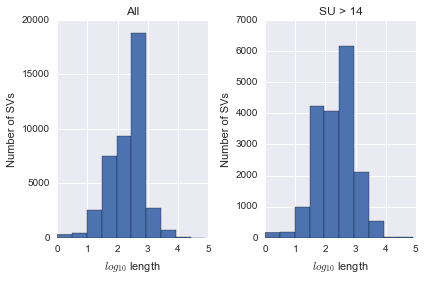

In [78]:
fig,axs = plt.subplots(1, 2)
ax = axs[0]
np.log10(lumpy_info.svlen.abs()).hist(ax=ax)
ax.set_ylabel('Number of SVs')
ax.set_xlabel('$log_{10}$ length');
ax.set_title('All')
ax = axs[1]
np.log10(lumpy_info[lumpy_info.su > 14].svlen.abs()).hist(ax=ax)
ax.set_ylabel('Number of SVs')
ax.set_xlabel('$log_{10}$ length')
ax.set_title('SU > 14');
fig.tight_layout()

In [79]:
lumpy_info.svtype.value_counts()

DEL    40185
DUP     2445
Name: svtype, dtype: int64

In [80]:
print(lumpy_info.svlen.abs().median())
print(lumpy_info[lumpy_info.svtype == 'DEL'].svlen.abs().median())
print(lumpy_info[lumpy_info.svtype == 'DUP'].svlen.abs().median())

301.0
294.0
524.0


In [81]:
cPickle.dump(lumpy_info, open(os.path.join(outdir, 'lumpy_info.pickle'), 'w'))

In [82]:
conv = {'0/0':0, '0/1':1, '1/1':2, './.':np.nan}
t = lumpy_genotypes.apply(lambda x: [conv[y] for y in x])
fn = os.path.join(private_outdir, 'lumpy_genotypes.tsv')
t.to_csv(fn, sep='\t')

In [83]:
out = os.path.join(outdir, 'lumpy_roadmap_overlap.tsv')
if not os.path.exists(out):
    url = ('http://egg2.wustl.edu/roadmap/data/byFileType'
           '/peaks/consolidated/narrowPeak/')
    website = urllib2.urlopen(url)
    html = website.read()
    files = re.findall('href="(.*\.gz)"', html)
    lines = [x for x in roadmap_ids.index if ('ES' in roadmap_ids[x] and 'Cultured' not in roadmap_ids[x])]
    lines += [x for x in roadmap_ids.index if 'iPS' in roadmap_ids[x]]
    files = [x for x in files if x.split('-')[0] in lines]
    files = [x for x in files if 'hotspot' not in x]

    roadmap_peak_pvals = pd.DataFrame(
        -1, index=lines, 
        columns=set([x.split('-')[1].split('.')[0] for x in files]))
    roadmap_peak_oddsratios = pd.DataFrame(
        0, index=lines, 
        columns=set([x.split('-')[1].split('.')[0] for x in files]))

    urls = ['http://egg2.wustl.edu/roadmap/data/byFileType/peaks/consolidated/narrowPeak/{}'.format(n)
            for n in files]
    lines = [roadmap_ids[re.findall('E\d{3}', url)[0]][0:-10].replace(' ', '_') for url in urls]
    btype = [re.findall('-(.+)\.', url)[0].split('.')[0] for url in urls]
    names = ['{}_{}'.format(lines[i], btype[i]) for i in range(len(lines))]
    todo = zip(urls, names)
    dview.push(dict(lumpy_bt=lumpy_bt, lumpy_info=lumpy_info));
    if cluster_ready == False:
        dview = cluster_setup()
        cluster_ready = True
    counts = dview.map_sync(lambda x: cnv_counts(lumpy_bt, lumpy_info, x[0], x[1]), todo)
    roadmap_dnase_counts = pd.concat(counts, axis=1)
    roadmap_dnase_counts.to_csv(out, sep='\t')
else:
    roadmap_dnase_counts = pd.read_table(out, index_col=0)

## Combined info

In [84]:
gs_info['svlen'] = gs_info.length
gs_info['svtype'] = gs_info.CNCATEGORY
gs_info['variant_caller'] = 'genomestrip'
lumpy_info['variant_caller'] = 'lumpy'
lumpy_info['emmax'] = False
lumpy_info.ix[lumpy_emmax_info.index, 'emmax'] = True
gs_info['emmax'] = False
gs_info.ix[cns_emmax_info.index, 'emmax'] = True
combined_info = pd.concat([lumpy_info, gs_info], join='inner')
fn = os.path.join(outdir, 'combined_info.pickle')
cPickle.dump(combined_info, open(fn, 'w'))

In [85]:
combined_info.head()

,chrom,start,end,name,overlaps_gene,contains_gene,overlaps_gene_exon,nearest_tss_dist,svlen,svtype,variant_caller,emmax
name,,,,,,,,,,,,
DEL_1_756790_757179,chr1,756790,757179,DEL_1_756790_757179,NaN,NaN,NaN,-3699,-389,DEL,lumpy,False
DEL_1_757414_758302,chr1,757414,758302,DEL_1_757414_758302,NaN,NaN,NaN,-4323,-888,DEL,lumpy,False
DEL_1_758133_758844,chr1,758133,758844,DEL_1_758133_758844,NaN,NaN,NaN,4042,-711,DEL,lumpy,False
DEL_1_859331_859613,chr1,859331,859613,DEL_1_859331_859613,NaN,NaN,NaN,647,-282,DEL,lumpy,False
DEL_1_869725_870228,chr1,869725,870228,DEL_1_869725_870228,{ENSG00000187634.6},NaN,NaN,-3281,-503,DEL,lumpy,True


## mCNVs

I want to identify mCNVs that I can test for associations with gene expression. 
I'll filter the mCNVs more in the notebook where I do the analysis. For now, I'll define
mCNVs as CNVs with more than three copy number states in my 131 unrelated individuals.
I'll keep mCNVs where there are more than 5 non-mode copy number estimates and more than 5
samples with copy number estimates outside the top three states.

In [86]:
t = gs_combined_cns[unr_rna_meta.wgs_id]
ns = t.apply(lambda x: len(set(x)), axis=1)
mcnvs = t[ns > 3]
# Remove CNVs in MHC.
t = gs_combined_info.ix[mcnvs.index]
s = '\n'.join(t.chrom + '\t' + t.start.astype(str) + '\t' + t.end.astype(str) + 
              '\t' + t.name) + '\n'
mcnv_bt = pbt.BedTool(s, from_string=True)
df = mcnv_bt.intersect(mhc_bt, wa=True, v=True).to_dataframe()
mcnvs = mcnvs.ix[df.name]

t = gs_combined_cns.ix[mcnvs.index, unr_rna_meta.wgs_id]
mode = t.mode(axis=1)[0]
nvariant = [sum(t.ix[i] != mode[i]) for i in t.index]
mcnvs = mcnvs[np.array(nvariant) > 5]
keep = []
for i in t.index:
    vc = t.round().ix[i].value_counts()
    if vc[vc.index[3:]].sum() > 5:
        keep.append(i)
mcnvs = mcnvs.ix[keep]

mcnvs.to_csv(os.path.join(private_outdir, 'mcnvs.tsv'), sep='\t')